In [1]:
import sys
sys.path.append('..')
from src.data.docx  import read_docx,process_docx,find_content
import glob
import json
import os
import pandas as pd
import ast
import warnings
warnings.filterwarnings("ignore")
from src.models.pipeline import pipeline
from src.features.segment_transcript import CreateBlocks
from functools import reduce
import heapq
from gensim.corpora import Dictionary
from gensim import models
from gensim import similarities
import re
import statistics
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display, HTML
from scipy.stats import entropy
import warnings
warnings.filterwarnings("ignore")

# READ BOOKS OF VIDEOS

In [2]:
'''Defining CONSTS'''
docx_path = '../data/raw/docx'
groundbase_dir = '../data/raw/groundbase'
transcripts_dir = os.path.join(groundbase_dir,'transcripts')
topic_dataset_path = os.path.join(groundbase_dir,'dataset.csv')
transcript_filespath = glob.glob(groundbase_dir + '/transcripts/*.json')
lemmatizing_method ='lemma' #'stemm'

In [3]:
videos_ids = list(map(lambda fl: fl.split('\\')[-1].split('.')[0],glob.glob(docx_path + '/*')))

In [4]:
desired_videos =['NuY7szYSXSw','XX7ePR21Ook','h9wxtqoa1jY','GJpt_3ie4WU','bTyxpoi2dmM']#['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ','zWg7U0OEAoE','tORLeHHtazM'] #['zWg7U0OEAoE','tORLeHHtazM'] #['7kLHJ-F33GI','RIawrYLVdIw','7snJ1mx1EMQ']
videos_ids = list(filter(lambda x: x in desired_videos,videos_ids))

In [5]:
#video_docx = [glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0] for vid in videos_ids]
#docx_db =[read_docx(path) for path in video_docx]
videos_ids

['bTyxpoi2dmM', 'GJpt_3ie4WU', 'h9wxtqoa1jY', 'NuY7szYSXSw', 'XX7ePR21Ook']

In [6]:
f_read = {
    'statbook':'statbook',
    'Dsa':'Dsa',
    'MIT6_042JF10_notes':'MIT6_042JF10_notes'
}

docxs_chapter_keyword = {
    'statbook':'Topic',
    'Dsa': 'Chapter',
    'MIT6_042JF10_notes':'Chapter'
}

In [7]:
video_to_paper = {}
paper_content ={}
for vid in videos_ids:
    doc_path = glob.glob(os.path.join(docx_path,vid + '/*.docx'))[0]
    doc_name = doc_path.split('\\')[-1].split('.')[0]
    video_to_paper[vid] = doc_name    
    if doc_name not in paper_content.keys():    
        full_text,font_sizes = read_docx(doc_path)
        paper_content[doc_name] = find_content(f_read[doc_name],
                                               full_text,
                                               font_sizes,
                                               docxs_chapter_keyword[doc_name],
                                              lemmatizing=lemmatizing_method)

# RESTORE RESULTS FROM TRAINING

In [8]:
'''Select transcript for only wanted videos'''
transcript_filespath = list(filter(lambda x: x.split('\\')[-1].split('.')[0] in videos_ids,transcript_filespath))

'''Read the transcript'''
transcripts_jsons = {}
for fl in transcript_filespath:
    with open(fl,encoding="utf8") as f:
        transcript =ast.literal_eval(f.read()) #json.load(f)
        vid = fl.split('\\')[-1].split('.')[0]
        #print(vid)
        transcripts_jsons[vid] = transcript
#print(transcripts_jsons)

'''Read the videos metadata to perform on them the segmentation'''
df_videos = pd.read_csv(topic_dataset_path)

''' Transfer topic shifts time to seconds units instead HH:MM:SS'''
def topic_shifts_seconds(topic_shifts):
    tp_shift_sec=[]
    for tp in topic_shifts:
        intervals = tp.split(':')
        seconds = int(intervals[2])
        minutes = int(intervals[1]) * 60
        hours = int(intervals[0]) * 60 *60
        tp_shift_sec.append(seconds + minutes + hours)
    return tp_shift_sec
for video_id in transcripts_jsons.keys():    
    df_videos.at[df_videos['video id'] == video_id,'topic shifts(ends)'] =\
    topic_shifts_seconds(\
                         df_videos[df_videos['video id'] == \
                                   video_id]['topic shifts(ends)'])
    

'''Get parameters from training'''
df_results = pd.read_csv('../data/processed/bayesian_opt/phrases/lemmas_adv_propn.csv')
n_largest_res = 3
pipeline_results = df_results[df_results['video'].isin(videos_ids)]\
                .groupby('video')[['video','workflow','params','max_target']]\
                .apply(lambda grp: grp.nlargest(n_largest_res,'max_target')).values.tolist()

pipeline_results = pipeline_results[:-1]#this is for zWg7U0OEAoE

    
    
    
def boundryevaluation(curresults,ground_base,accurrcy_shift = 30):
        true_positive = 0
        false_negative = 0
        false_positive = 0 
        true_positive_list_debug = []
        #false_negative_list_debug = []
        false_positive_list_debug = []
        results = curresults[:]
        
        
        #print('curresults %s' %(curresults))
        #print('ground_base %s ' %(ground_base))
        
        for grb in ground_base:
            is_false_positive = True
            for res in results:     
                if abs(res - grb) < accurrcy_shift:
                    is_false_positive = False
                    true_positive_list_debug.append(res)
                    true_positive+=1
                    results.remove(res)
                    break   
            if is_false_positive:
                false_positive_list_debug.append(grb)
                false_positive+=1
                
        #print("TP: " + str(true_positive_list_debug))
        #print("FP: " + str(false_positive_list_debug))
        #print("FN: " + str(curresults))
        #print('true_positive : %s ' %(true_positive))
        false_negative = len(results) # make sure the true positive are removed from here 
        recall_rate = true_positive/(true_positive + false_negative )
        precision_rate = true_positive/(true_positive + false_positive)
        #print("TP: %s , FP: %s, FN: %s" %(true_positive,false_positive,false_negative))
        #print("precision rate : %s, recall rate : %s " % (precision_rate,recall_rate))
        return precision_rate

    


In [9]:
videos_division = {}

for vid in videos_ids:
    vid_results = list(filter(lambda x: x[0] == vid,pipeline_results))
    max_precision = 0
    vid_words = None
    vid_shifts = None
    for result in vid_results:
        '''From the get optimized by bayesian we get that for the video '''
        vid = result[0]
        params = ast.literal_eval(result[2]) #{'n_clusters': 18, 'sim_thresh': 0.6, 'step_size': 49, 'window_size': 150}
        #print(params)
        for key in ['n_clusters','step_size','window_size']:
            params[key] = int(params[key])# - 1
        workflow = result[1] #'sliding_window-tfidf-cosine-median_(3,3)-spectral_clustering'
        
        shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
        groundbase = shifts[:-1]
        transcripts = transcripts_jsons[vid]
        #print(grounbase)
        _pipeline = workflow.split('-')
        filter_type = None
        mask_shape = None
        filtering = _pipeline[3]
        if filtering != 'None':
            filter_type = filtering.split('_')[0]
            mask_shape = ast.literal_eval(filtering.split('_')[1])
        '''This running may not work at first time do not give up and run it couple of times'''

        '''print('Running the following %s for video %s with params %s %s %s'
              %(workflow, vid,params,filter_type,mask_shape))'''
        #print(vid_results[1])
        #print(str(filter_type) + " " + str(mask_shape))
        shift_times,topic_words = (None,None)
        n_trials = 7
        while shift_times is None and topic_words is None and n_trials > 0:
            print('##################################################')
            print("running trial %s for vid %s desired precision %s "%(n_trials,vid,result[3]))
            n_trials= n_trials - 1
            shift_times,topic_words = pipeline.run_for_baye(groundbase,
                                                            transcripts,
                                                            slicing_method='sliding_window',
                                                            window_size=params['window_size'],#59
                                                            step_size_sd= params['step_size'], #10
                                  vector_method='tfidf',vectorizing_params=None,
                                  similarity_method='cosine',
                                  filter_params={"filter_type":filter_type,
                                                 "mask_shape":mask_shape,
                                                 "sim_thresh": params['sim_thresh'], #0.5160973480326474 
                                                 "is_min_thresh":True
                                                 },
                                 clustering_params={
                                         'algorithm':'spectral_clustering',
                                         'n_clusters':params['n_clusters'] #14
                                         },
                                        accurrcy_shift=30,
                                        return_value='division') or (None,None)

            if shift_times is not None:
                pr = boundryevaluation(shift_times,groundbase,accurrcy_shift=45)
                print("output precision %s " %(pr))
                
                if pr > max_precision:
                    print("new high percision caught")
                    max_precision = pr 
                    vid_words = topic_words
                    shift_times.append('end')
                    vid_shifts = shift_times 
                if pr < result[3]:
                    shift_times,topic_words = (None,None)    

    videos_division[vid] = {'topic_words':vid_words,'topic_shift':vid_shifts}

##################################################
running trial 7 for vid bTyxpoi2dmM desired precision 0.875 
label 2 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 2 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 6 for vid bTyxpoi2dmM desired precision 0.875 
label 19 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 19 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 5 for vid bTyxpoi2dmM desired precision 0.875 
label 0 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 0 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 4 for vid bTyxpoi2dmM desired precision 0.875 
The results:
[83, 151, 279, 433, 613, 764, 902, 1069, 1252, 1485, 1647, 1802, 2021, 2239, 2355, 2594, 2829, 3028, 3147, 3246, 3420, 3578, 3762, 3891, 4214, 4553, 4764, 4989]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.625 
new high percision caught
##################################################
running trial 3 for vid bTyxpoi2dmM desired precision 0.875 
label 10 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 10 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 2 for vid bTyxpoi2dmM desired precision 0.875 
label 10 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 10 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 1 for vid bTyxpoi2dmM desired precision 0.875 
label 10 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 10 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 7 for vid bTyxpoi2dmM desired precision 0.75 
The results:
[113, 190, 332, 433, 633, 840, 1011, 1196, 1368, 1526, 1638, 1779, 1964, 2204, 2358, 2604, 2830, 3043, 3190, 3350, 3551, 3707, 3895, 4109, 4496, 4610, 4984]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.875 
new high percision caught
##################################################
running trial 7 for vid bTyxpoi2dmM desired precision 0.75 
The results:
[95, 294, 490, 628, 796, 927, 1084, 1256, 1429, 1656, 1795, 1932, 2103, 2292, 2484, 2648, 2836, 3055, 3169, 3232, 3440, 3652, 3854, 4014, 4187, 4561, 4737, 4973]
The ground base:
[90, 360, 665, 885, 985, 1620, 2233, 3220]
output precision 0.625 
##################################################
running trial 6 for vid bTyxpoi2dmM desired precision 0.75 
The results:
[95, 294, 439, 532, 659, 905, 1061, 1256, 1429, 1656, 1795, 1932, 2103, 2259, 2484, 2648, 2836, 3055, 3137, 32

new high percision caught
##################################################
running trial 7 for vid NuY7szYSXSw desired precision 0.875 
The results:
[163, 235, 315, 390, 479, 624, 791, 987, 1178, 1311, 1510, 1716, 1867, 2030, 2210, 2387, 2533, 2691, 2936, 3093, 3318, 3507, 3655, 3979, 4206, 4393, 4605, 4810]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.75 
new high percision caught
##################################################
running trial 6 for vid NuY7szYSXSw desired precision 0.875 
The results:
[163, 235, 324, 461, 582, 697, 853, 1052, 1194, 1311, 1510, 1699, 1832, 1994, 2180, 2283, 2422, 2533, 2710, 2936, 3093, 3318, 3507, 3655, 4075, 4348, 4587, 4810]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.75 
##################################################
running trial 5 for vid NuY7szYSXSw desired precision 0.875 
The results:
[129, 213, 302, 348, 479, 624, 791, 1003, 1194, 1343, 1510, 1744, 1946, 2053

Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 16 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 6 for vid NuY7szYSXSw desired precision 0.875 
The results:
[189, 251, 291, 450, 585, 811, 1088, 1251, 1464, 1688, 1827, 1956, 2123, 2222, 2384, 2537, 2664, 2938, 3089, 3240, 3377, 3564, 3811, 4103, 4297, 4466, 4811]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.625 
##################################################
running trial 5 for vid NuY7szYSXSw desired precision 0.875 
label 25 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 25 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 4 for vid NuY7szYSXSw desired precision 0.875 
The results:
[189, 251, 341, 496, 703, 868, 1194, 1343, 1507, 1688, 1774, 1956, 2123, 2270, 2438, 2537, 2664, 2886, 3037, 3240, 3331, 3471, 3620, 3996, 4297, 4466, 4811]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.625 
##################################################
running trial 3 for vid NuY7szYSXSw desired precision 0.875 
label 25 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 25 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 2 for vid NuY7szYSXSw desired precision 0.875 
label 27 has done already cannot evaluate unsequentional segmentation, try other parameters


Traceback (most recent call last):
  File "..\src\models\pipeline.py", line 266, in run_for_baye
    accurrcy_shift)
  File "..\src\models\clustering.py", line 139, in run
    myresults = clustering.boundery_change(clustering_results.labels_,gap_timestamp)
  File "..\src\models\clustering.py", line 91, in boundery_change
    raise Exception("label %s has done already cannot evaluate unsequentional segmentation, try other parameters" % (block_labeles[blk_index]))
Exception: label 27 has done already cannot evaluate unsequentional segmentation, try other parameters


None
##################################################
running trial 1 for vid NuY7szYSXSw desired precision 0.875 
The results:
[101, 189, 291, 405, 496, 703, 924, 1194, 1343, 1562, 1774, 1956, 2123, 2222, 2384, 2537, 2664, 2938, 3089, 3286, 3377, 3471, 3564, 3869, 4226, 4466, 4811]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.5 
##################################################
running trial 7 for vid NuY7szYSXSw desired precision 0.75 
The results:
[126, 200, 248, 334, 475, 641, 864, 1132, 1287, 1506, 1737, 1949, 2052, 2232, 2434, 2637, 2952, 3124, 3310, 3492, 3680, 4073, 4315, 4503, 4814]
The ground base:
[520, 590, 1835, 2028, 2090, 2570, 3470, 4320]
output precision 0.375 
##################################################
running trial 6 for vid NuY7szYSXSw desired precision 0.75 
The results:
[145, 241, 334, 475, 659, 864, 1113, 1271, 1506, 1726, 1893, 2010, 2195, 2295, 2473, 2659, 2952, 3105, 3310, 3492, 3580, 3992, 4315, 4503, 4814]
The

In [10]:
#videos_division

# EXTRACT MAIN CHAPTERS OF BOOKS AND ORAGANIZE THE PAPER AS DIFFERENT DOCUMENTS GROUPS

In [11]:
'''Regex to identify '''
p_firstsubsection = re.compile(r'((\d+\.)+\d*\t[A-Za-z0-9? ]+)')

In [12]:
'''Find the following for each paper:
    1) main chapter title index. for example [10,15....]
    2) range of subsection within each main chapter . for example [(0,9),(11,14)...]
    
    '''

#paper_mainchapter_indexes = {}
paper_sec_within_main_indexes = {}
main_section_as_one_doc = {}
paper_subsec_as_one_doc = {}
first_dep_section_as_one_doc = {}

def get_sub_titles(all_titles,main_tl_indexes):
    subsec_mainchapter_indexes = [range(main_tl_indexes[index],main_tl_indexes[index + 1])
                                  for index in range(len(main_tl_indexes) - 1)]
    subsec_mainchapter_indexes.append(range(main_tl_indexes[-1],len(all_titles)))
    return subsec_mainchapter_indexes


for doc_name in paper_content.keys():
    '''
        first element array of subtitles by dividing based on main chapters like 4 number theory
        second element array of subtitles by dividing based on main first hierarchy depth titles like 4.1 simple graph 
    '''
    titles_by_hierchy_ranges = [] 
    titles_by_hierchy_indexes = []
    
    '''Find the main chapter indexes in the list of the overall titles'''
    '''Titles like 4 Number theory or 5 Graphs'''
    mainchapter_indexes = [paper_content[doc_name]['titles'].index(ch_title)
                           for ch_title in paper_content[doc_name]['main titles']]
    titles_by_hierchy_indexes.append(mainchapter_indexes)
    
    '''
        Find the indexes of the first depth subsection
        for example 4.1 simple graphs
    '''
    tl_first_dep_by_hier_indexes = [i for i,tl in enumerate(paper_content['MIT6_042JF10_notes']['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    titles_by_hierchy_indexes.append(tl_first_dep_by_hier_indexes)
    
    tl_first_dep_by_hier = [tl for i,tl in enumerate(paper_content['MIT6_042JF10_notes']['titles'])
     if re.match(r'(^([0-9]+\.[0-9]*)$)',tl) is not None or
     re.match(r'[0-9]+\.[0-9]*\s+',tl) is not None]
    
    '''Adding the indexes of the first dep subsections to the main indexes'''
    '''For example the fourth place will contains the indexes of the titles: 4.1,4.2,4.3'''
    top_maintitle_ranges = []

    for index in range(len(mainchapter_indexes) - 1):
        j = mainchapter_indexes[index]
        range_j = []
        while j < mainchapter_indexes[index + 1]:
            '''If this title is from the shape like 4.1 or 4.2'''
            curr_tl = paper_content['MIT6_042JF10_notes']['titles'][j]
            if j in tl_first_dep_by_hier_indexes:
                range_j.append(tl_first_dep_by_hier.index(curr_tl))
            j+=1
        top_maintitle_ranges.append(range_j)
    '''Adding the last one'''
    j = mainchapter_indexes[-1]
    range_j = []
    while j < len(paper_content[doc_name]['titles']):
        curr_tl = paper_content['MIT6_042JF10_notes']['titles'][j]
        if j in tl_first_dep_by_hier_indexes:
            range_j.append(tl_first_dep_by_hier.index(curr_tl))
        j+=1
    top_maintitle_ranges.append(range_j)
        
    titles_by_hierchy_ranges.append(top_maintitle_ranges)
    
    '''adding the ranges of the subtitles of the first depth of each '''
    '''like for example for title 4.1 the range will be the indexes of the titles
        4.1.1,4.1.2 etc'''
    titles_by_hierchy_ranges.append(get_sub_titles(paper_content[doc_name]['titles'],
                                                             titles_by_hierchy_indexes[1]))
    
    
    '''Making each chapter as a one documents'''
    
    '''Union all the documents in a atomic section into single document'''
    paper_subsec_as_one_doc[doc_name] = [list(reduce(lambda doc,acc:doc + acc,sec,[]))
                                         for sec in paper_content[doc_name]['corpus']]
    
    
    '''Sections are like 4.1 simple graph'''
    first_dep_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   paper_subsec_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[1]]

    
    '''Union all the sub section in a main chapter into one document'''
    '''sections are like 4 Number theory'''
    main_section_as_one_doc[doc_name] = [list(reduce(lambda acc,s_i:
                                                   first_dep_section_as_one_doc[doc_name][s_i]+acc,
                                                    subsec_indexes,[]))
                                        for subsec_indexes in titles_by_hierchy_ranges[0]]
    

In [13]:
#paper_subsec_as_one_doc['statbook'][0]

In [14]:
#print(len(paper_content['MIT6_042JF10_notes']['titles']))
#print(len(paper_content['MIT6_042JF10_notes']['corpus']))
##print(len(paper_content['MIT6_042JF10_notes']['main titles']))
#print(len(main_section_as_one_doc['MIT6_042JF10_notes']))
print((titles_by_hierchy_ranges[0][5]))
print(len(titles_by_hierchy_ranges[0]))
print(len(first_dep_section_as_one_doc['MIT6_042JF10_notes']))
print(len(titles_by_hierchy_ranges[1]))
print(len(main_section_as_one_doc['MIT6_042JF10_notes']))
print(len(paper_content['MIT6_042JF10_notes']['main titles']))
#print(titles_by_hierchy_ranges[0][-1])
#print(tl_first_dep_by_hier)
print(tl_first_dep_by_hier[18])
print(first_dep_section_as_one_doc['MIT6_042JF10_notes'][18])

[33, 34, 35]
20
110
110
20
20
4.2 The Greatest Common Divisor
['pulverizer', 'unfortunately', 'proof', 'nonconstructive', 'suggest', 'way', 'find', 'job', 'tackle', 'mathematical', 'tool', 'date', 'sixth', 'century', 'india', 'call', 'kuttak', 'mean', 'pulverizer', 'today', 'pul', 'verizer', 'commonly', 'know', 'extended', 'euclidean', 'gcd', 'algorithm', 'close', 'euclid', 'algorithm', 'example', 'compute', 'gcd', 'follow', 'gcd', 'gcd', 'gcd', 'rem', 'rem', 'rem', 'rem', 'begin', 'initialize', 'variable', 'first', 'column', 'carry', 'euclid', 'algorithm', 'step', 'compute', 'rem', 'write', 'form', 'remember', 'division', 'algorithm', 'say', 'remainder', 'rearranging', 'term', 'replace', 'equation', 'equivalent', 'linear', 'combina', 'tion', 'already', 'compute', 'simplify', 'left', 'chapter_number', 'theory', 'linear_combination', 'equal', 'remainder', 'desire', 'solution', 'water_jug', 'problem', 'corollary', 'say', 'write', 'linear_combination', 'multiple', 'gcd', 'word', 'exist', 

In [15]:
'''Find phrasers of books  '''
paper_phrasers = {}
for doc_name in main_section_as_one_doc.keys():
    paper_phrasers[doc_name] = list(set(reduce(lambda acc,x: acc+x,
                                      [[w for w in ch if '_' in w]
                                      for ch in main_section_as_one_doc[doc_name]])))

In [16]:
#paper_phrasers['Dsa']

# FIND CORRELATION BETWEEN MAIN CHAPTERES AND FOUNDED TOPICS IN THE VIDEO 

In [17]:
def find_top_words_of_topic(topic_words,chapter_titles=None):
    for tp_i,tp_words in enumerate(topic_words):
        #
        raw_text = ' '.join(tp_words)
        myvectorizer = CountVectorizer()
        mytf = myvectorizer.fit_transform([raw_text]).toarray()
        #print(mytf)
        maxes = heapq.nlargest(3,mytf[0])
        indexes = []
        for i,bal in enumerate(mytf[0]):
            if bal in maxes:
                indexes.append(i)
        ws = [myvectorizer.get_feature_names()[_] for i,_ in enumerate(indexes)]
        
        if chapter_titles is None:
            print('top words for topic %s are %s' %(tp_i,ws))
        else:
            print('top words for topic %s are %s' %(chapter_titles[tp_i],ws))

In [18]:
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import spacy
from nltk.stem import PorterStemmer
stop_words = stopwords.words('english')
nlp = spacy.load('en',disable=['parser','ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB','PROPN','ADV']#['NOUN', 'ADJ', 'VERB','ADV']#['NOUN', 'ADJ', 'VERB','PROPN']# #['NOUN', 'ADJ', 'VERB']
porter = PorterStemmer()

In [19]:
def emphasize_title(doc_name,book_chapters,titles,factor_enrich = 20,lemmatizing = "lemma"):
    chapters_enriched = book_chapters[:]
    
    for index,tl in enumerate(titles):
        tl_text_no_punc = simple_preprocess(tl,deacc=True) 
        tokenized_text_non_stop_words = [ word for word in tl_text_no_punc 
                                         if word not in stop_words]
        """text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
        tokenized_lemmas = nlp(text_non_stop_words)
        tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                            if token.pos_ in allowed_postags]"""
        
        if lemmatizing == "stemm":
            tokenized_lemmas = [porter.stem(w) for w in tokenized_text_non_stop_words]
        else:
            text_non_stop_words = ' '.join(tokenized_text_non_stop_words)
            tokenized_lemmas = nlp(text_non_stop_words)
            tokenized_lemmas = [token.lemma_ for token in tokenized_lemmas \
                                if token.pos_ in allowed_postags]

        
        
        tokenized_lemmas_ph = '_'.join(tokenized_lemmas)#reduce(lambda acc,x: acc+x,
        #print('tokenized_lemmas_ph %s' %(tokenized_lemmas_ph))
        
        if tokenized_lemmas_ph in paper_phrasers[doc_name]:
            tokenized_lemmas =[tokenized_lemmas_ph]
        
        chapters_enriched[index] = chapters_enriched[index] + tokenized_lemmas * factor_enrich
    return chapters_enriched

In [28]:
def get_topic_chapter_corr_tfidf(paper_name,book_chapters,
                                 vid_topics_words,vid_topics_shift,
                                 dispaly_titles,pre_labeled_title=None,is_print_mess=True):
    raw_book_video = []
    for tp_vid in vid_topics_words:
        raw_book_video = raw_book_video + [tp_vid]
    
    for ch in book_chapters:
        raw_book_video = raw_book_video + [ch]

    # creating dictionary of all of the words in the corpus of the video and the paper
    #print(len(raw_book_video))
    dictionary = Dictionary(raw_book_video)
    #dictionary = Dictionary(book_chapters)
    
    #ch_dict = Dictionary(book_chapters)
    #vid_dict = Dictionary(vid_topics_words)
    
    the_dictionary = dictionary
    
    #whole_corpus = vid_topics_words + book_chapters
    #bgw_corpus = [dictionary.doc2bow(doc) for doc in whole_corpus]
    bgw_chapter = [the_dictionary.doc2bow(doc) for doc in book_chapters]
    bgw_vids = [the_dictionary.doc2bow(doc) for doc in vid_topics_words]
    
    '''Calculate the pivot '''
    _tmp =  [len(list(set([w for w in ch]))) for ch in book_chapters]
    book_pivot = sum(_tmp)/len(_tmp)
    _tmp = [len(list(set([w for w in ch]))) for ch in vid_topics_words]
    vid_pivot = sum(_tmp)/len(_tmp)
    
    tf_idf_model_ch = models.TfidfModel(bgw_chapter,
                                        dictionary=the_dictionary#,
                                        #pivot=book_pivot#,
                                        #slope=0.8,
                                        #smartirs='nnc'
                                       ) #,
    tf_idf_model_vid = models.TfidfModel(bgw_vids,
                                         dictionary=the_dictionary#,
                                         #pivot=vid_pivot#,
                                         #slope=0.4
                                        )#,smartirs='lfc'
    
    index_sim = similarities.SparseMatrixSimilarity(tf_idf_model_ch[bgw_chapter],
                                                    num_features=len(the_dictionary))
    
    correlation = [[s for s in index_sim[tf_idf_model_vid[doc]]] for doc in bgw_vids]
    #print(tf_idf_model[bgw_vids])
    
    # find the top n words in the topic (in the video)
    #print('$$$$$$$$$$$$$$top words of video topic$$$$$$$$$$$$$$')
    #find_top_words_of_topic(videos_division[vid]['topic_words'])
    #print('$$$$$$$$$$$$$$top words of book chapters$$$$$$$$$$$$$$')
    #find_top_words_of_topic(book_chapters,chapter_titles=dispaly_titles)
    
    
    
    # normalizing the correlation between each topic and chapter 
    for i_t in range(len(correlation)):
        sum_ = sum(correlation[i_t])
        for ch_index in range(len(correlation[i_t])):
            correlation[i_t][ch_index] = correlation[i_t][ch_index]/sum_
    
    corr_as_row = reduce(lambda x,y: x+y,correlation,[] ) # to get the global max in min
    
    if is_print_mess:
        sns.heatmap(correlation,vmin=min(corr_as_row),vmax=max(corr_as_row))
        plt.show()
    
    
    
    # find the cha
    ch_matching_top = []
    #print(len(correlation[0]))
    
    
    for i,corr in enumerate(correlation):
        max_cor = max(corr) # max correlation with that topic
        #shift = vid_topics_shift[i]
        founded_title = dispaly_titles[corr.index(max_cor)]
        #ch_matching_top.append(paper_mainchapter_indexes[paper_name][corr.index(max_cor)])
        ch_matching_top.append(founded_title)

    
    
    hit = 0 
    miss = 0
    
    if pre_labeled_title is not None:
        print(vid)
        shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
        groundbase = shifts#[:-1] # not removing the end string - modify it in the next lines
        vid_topics_shift[-1] = groundbase[-1] # converting the 'end' string to 
        df_vid_results = pd.DataFrame(columns=['Video',
                                               'Video Shift',
                                               'Founded Title',
                                               'Similarity Ratio',
                                               'Chapter Section',
                                               'Prelabeled Title',
                                               'Labeling Confidence'])
        for i,corr in enumerate(correlation):
            max_cor = max(corr) # max correlation with that topic
            shift = vid_topics_shift[i]
            closest_grb_index = 0
            for grb_i in range(len(groundbase)):
                if abs(int(groundbase[grb_i])- shift) < abs(int(groundbase[closest_grb_index]) - shift):
                    closest_grb_index = grb_i
            
            founded_title = dispaly_titles[corr.index(max_cor)]
            df_vid_results = df_vid_results.append({
                                   'Video' :vid,
                                   'Video Shift': sec_to_min(shift),
                                   'Founded Title':founded_title,
                                   'Similarity Ratio':max_cor,
                                   'Chapter Section':pre_labeled_title[closest_grb_index][0],
                                   'Prelabeled Title':pre_labeled_title[closest_grb_index][1],
                                   'Labeling Confidence':pre_labeled_title[closest_grb_index][2]},ignore_index=True)

        display(HTML(df_vid_results[['Video Shift',
                                    'Founded Title',
                                    'Similarity Ratio',
                                    'Chapter Section',
                                    'Prelabeled Title',
                                    'Labeling Confidence']].to_html()))
    elif is_print_mess:
        for i,corr in enumerate(correlation):
            max_cor = max(corr) # max correlation with that topic
            shift = vid_topics_shift[i]
            print (" video_shift index %s at %s , chapter title %s ( index %s) " 
                   %(i,
                     sec_to_min(shift),
                     dispaly_titles[corr.index(max_cor)],
                     corr.index(max_cor)
                     ))

    return ch_matching_top,correlation

def find_dominent_main_chapter(ch_tp_corr,titles,correlation):
    
    '''Find the frequency of each chapter'''
    chapter_matching_counts_max = [max([ch_tp_corr.count(ch) for ch in ch_tp_corr])]
    for max_count in chapter_matching_counts_max:
        #print("####### #######")
        '''Find the most frequent chapter'''
        #print(([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        dominent_chapters = list(set([ch for ch in ch_tp_corr if ch_tp_corr.count(ch) == max_count]))
        #print(dominent_chapters)
        
        # if we have absulote majority on topic
        if len(dominent_chapters) == 1:
            return dominent_chapters[0]
        else:
            # draw between topics, decide which one by taking this with the high variance
            index_winner = 0
            df_ch_corr = pd.DataFrame.from_records(correlation)
            for j_dom in range(len(dominent_chapters)):
                first = df_ch_corr.var()[titles.index(dominent_chapters[index_winner])]
                #print(first)
                second = df_ch_corr.var()[titles.index(dominent_chapters[j_dom])]
                #print(second)
                if first > second:
                    index_winner = j_dom
            return (dominent_chapters[index_winner])
        
            
import time    
def sec_to_min(seconds):
    if seconds == 'end':
        return 'end'
    return time.strftime('%H:%M:%S', time.gmtime(seconds))



In [21]:
'''my hand tuning data frame'''

df_tp_to_ch = pd.read_csv(os.path.join(groundbase_dir,'Topic to chapter.csv'))
df_tp_to_ch  = df_tp_to_ch.replace({np.nan:None})

In [64]:
chapters_matching_topics = {}
all_results_matching = []
#for vid in videos_ids:
for vid in videos_ids:
    print('################ %s ################' % (vid))
    paper_name = video_to_paper[vid]
    correlations_levels = []
    
    
    
    '''Finding the correlation between topic and main chapters'''
    main_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 main_section_as_one_doc[paper_name],
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 paper_content[paper_name]['main titles'],is_print_mess=False)
    
    correlations_levels.append(correlation)
    #print(main_matching_topic)
    dominet_chapter =  find_dominent_main_chapter(main_matching_topic,
                                                  paper_content[paper_name]['main titles'],
                                                 correlation)
    print('By the majority vote, the dominent chapter choosed is %s ' %(dominet_chapter))
    
    '''Finding correlation to the first dep sections within the selected main chapter'''
    dom_main_cha_index = paper_content[paper_name]['main titles'].index(dominet_chapter)
    print(dom_main_cha_index)
    dom_subsec_text = [first_dep_section_as_one_doc[paper_name][s_i]
                       for s_i in titles_by_hierchy_ranges[0][dom_main_cha_index]]
    dom_subsec_titles = [tl_first_dep_by_hier[tl_i]
                         for tl_i in titles_by_hierchy_ranges[0][dom_main_cha_index]]
    
    dom_subsec_text = emphasize_title(paper_name,dom_subsec_text,
                                      dom_subsec_titles,lemmatizing = lemmatizing_method)
    
    
    subsec_matching_topic,correlation = get_topic_chapter_corr_tfidf(paper_name,
                                 dom_subsec_text,
                                 videos_division[vid]['topic_words'],
                                 videos_division[vid]['topic_shift'],
                                 dom_subsec_titles,is_print_mess=False)
    
    correlations_levels.append(correlation)
    #measure_confidence(vid,correlations_levels)
    section_to_topic = []
    #topics_correlations = []
    '''Finding the third ganular level of chossing the chapter'''
    
    for tp_i,section in enumerate(subsec_matching_topic):
        '''
            Finding the subsections title and texts of the first dep section (4.1 etc)
        '''
        curr_first_dep_tl_index = tl_first_dep_by_hier.index(section)
        subsec_range = titles_by_hierchy_ranges[1][curr_first_dep_tl_index]
        subsection_titles = [paper_content[doc_name]['titles'][tl_i] for tl_i in  subsec_range]
        subsection_text = [paper_subsec_as_one_doc[doc_name][tx_i] for tx_i in subsec_range]
        subsection_text = emphasize_title(paper_name,subsection_text,
                                      subsection_titles,lemmatizing = lemmatizing_method)
        
        topic_matching,topic_corr = get_topic_chapter_corr_tfidf(paper_name,
                                                                 subsection_text,
                                                                 [videos_division[vid]['topic_words'][tp_i]],
                                                                 None,
                                                                 subsection_titles,
                                                                 is_print_mess=False
                                                                )
        section_to_topic = section_to_topic + topic_matching
    
    
    
    
    '''###################################'''
    '''Extracting all pre labeled topics '''
    '''####################################'''
    pre_labeled_titles = df_tp_to_ch.loc[df_tp_to_ch['video id'] == vid,
                        ['chapter section','chapter title','chapter confidence']].values.tolist()
    
    pre_labeled_titles.insert(0,{'chapter section':0,'chapter title':'Start of lecture','chapter confidence':0})
    
    
    '''Find the match between the topics to the chapter at the most granular way'''
    
    shifts = df_videos.loc[df_videos['video id'] == vid,'topic shifts(ends)'].values.tolist()
    groundbase = shifts#[:-1] # not removing the end string - modify it in the next lines
    videos_division[vid]['topic_shift'][-1] = groundbase[-1] # converting the 'end' string to 
    df_vid_results = pd.DataFrame(columns=['Video',
                                           'Segment Time Range',
                                           'Founded Title',
                                           'Chapter Section',
                                           'Prelabeled Title',
                                           'Groundbase Interval'])
    
    previous_shift = 0
    groundbase.insert(0,0)
    for topic_i in range(len(videos_division[vid]['topic_shift'])):
        #max_cor = max(corr) # max correlation with that topic
        
        #print(groundbase)
        curr_shift = videos_division[vid]['topic_shift'][topic_i]
        intermax_grb_previous_index = 0
        intermax_grb_next_index = 1
        max_intersection = min(curr_shift,groundbase[intermax_grb_next_index]) - max(previous_shift,groundbase[intermax_grb_previous_index])
        for grb_previous_index,grb_next_index in zip(range(0,len(groundbase) - 1,1),range(1,len(groundbase),1)):
            upper_bound = min(curr_shift,groundbase[grb_next_index])
            bottom_bound = max(previous_shift,groundbase[grb_previous_index])
            curr_intersection =  upper_bound- bottom_bound
            if  curr_intersection > max_intersection:
                '''print("topic_i : " + str(topic_i)+ " groundbase[grb_previous_index] : " +str(groundbase[grb_previous_index])+
                      " groundbase[grb_next_index]: " +str(groundbase[grb_next_index]) + ' previous_shift : ' +str(previous_shift)+
                     " curr_shift: " +str(curr_shift)  + 'upper_bound : ' + str(upper_bound) + " bottom_bound: " + str(bottom_bound))
                print('curr_intersection ' +str(curr_intersection) + 'max_intersection ' + str(max_intersection))'''
                intermax_grb_previous_index = grb_previous_index
                intermax_grb_next_index = grb_next_index
                max_intersection = curr_intersection
        
        founded_title = section_to_topic[topic_i]
        df_vid_results = df_vid_results.append({
                               'Video' :vid,
                               'Segment Time Range': sec_to_min(previous_shift) + "-"  +sec_to_min(curr_shift),
                               'Founded Title':founded_title,
                               'Chapter Section':pre_labeled_titles[intermax_grb_next_index][0],
                               'Prelabeled Title':pre_labeled_titles[intermax_grb_next_index][1],
                               'Groundbase Interval': sec_to_min(groundbase[intermax_grb_previous_index])+ "-" +sec_to_min(groundbase[intermax_grb_next_index])},ignore_index=True)
        previous_shift = curr_shift

    display(HTML(df_vid_results[[
                                'Segment Time Range',
                                'Founded Title',
                                'Chapter Section',
                                'Prelabeled Title',
                                 'Groundbase Interval']].to_html()))
    display(df_tp_to_ch.loc[df_tp_to_ch['video id'] == vid])
    all_results_matching.append(df_vid_results)

    

################ bTyxpoi2dmM ################
By the majority vote, the dominent chapter choosed is Directed Graphs 
5


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:01:53,6.3 Communication Networks,6.3,Communication Networks,00:00:00-00:01:30
1,00:01:53-00:03:10,6.3.2 The Complete Binary Tree,6.3.2,The Complete Binary Tree,00:01:30-00:06:00
2,00:03:10-00:05:32,6.3.2 The Complete Binary Tree,6.3.2,The Complete Binary Tree,00:01:30-00:06:00
3,00:05:32-00:07:13,6.3.3 Network Diameter,6.3.3,Network Diameter,00:06:00-00:11:05
4,00:07:13-00:10:33,6.3.3 Network Diameter,6.3.3,Network Diameter,00:06:00-00:11:05
5,00:10:33-00:14:00,6.3.3 Network Diameter,6.3.4,Switch Size,00:11:05-00:14:45
6,00:14:00-00:16:51,6.3.5 Switch Count,6.3.5,Switch Count,00:14:45-00:16:25
7,00:16:51-00:19:56,6.3.6 Congestion,6.3.6,Congestion,00:16:25-00:27:00
8,00:19:56-00:22:48,6.1 Definitions,6.3.6,Congestion,00:16:25-00:27:00
9,00:22:48-00:25:26,6.3.6 Congestion,6.3.6,Congestion,00:16:25-00:27:00


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
93,0,00:01:30,None,None,bTyxpoi2dmM,6.3,Communication Networks,None,None
94,1,00:06:00,None,None,bTyxpoi2dmM,6.3.2,The Complete Binary Tree,None,None
95,2,00:11:05,None,None,bTyxpoi2dmM,6.3.3,Network Diameter,None,None
96,3,00:14:45,None,None,bTyxpoi2dmM,6.3.4,Switch Size,None,None
97,4,00:16:25,None,None,bTyxpoi2dmM,6.3.5,Switch Count,None,None
98,5,00:27:00,None,None,bTyxpoi2dmM,6.3.6,Congestion,None,None
99,6,00:37:13,None,None,bTyxpoi2dmM,6.3.7,The 2-d Array,None,None
100,7,00:53:40,None,None,bTyxpoi2dmM,6.3.8,The Butterfly,None,None
101,8,01:23:24,None,None,bTyxpoi2dmM,6.3.9,Benes Network,None,None


################ GJpt_3ie4WU ################
By the majority vote, the dominent chapter choosed is Graph Theory 
4


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:02:08,5.4.1 Paths and Walks,5.4.1,Paths and Walks,00:00:00-00:05:24
1,00:02:08-00:05:39,5.4.1 Paths and Walks,5.4.1,Paths and Walks,00:00:00-00:05:24
2,00:05:39-00:12:18,5.4.1 Paths and Walks,5.4.2,Finding a Path,00:05:24-00:12:13
3,00:12:18-00:14:52,5.5.2,5.5,Connectivity,00:12:13-00:14:15
4,00:14:52-00:17:35,5.6.1 Cycles and Closed Walks,5.6.1,Cycles and Closed Walks,00:14:15-00:16:55
5,00:17:35-00:20:06,5.5.2,5.7.1,Definitions,00:16:55-00:18:55
6,00:20:06-00:21:46,5.7.4 Minimum Weight Spanning Trees,5.7.2,Properties,00:18:55-00:30:20
7,00:21:46-00:22:34,5.7.4 Minimum Weight Spanning Trees,5.7.2,Properties,00:18:55-00:30:20
8,00:22:34-00:24:24,5.7.4 Minimum Weight Spanning Trees,5.7.2,Properties,00:18:55-00:30:20
9,00:24:24-00:27:24,5.7.2 Properties,5.7.2,Properties,00:18:55-00:30:20


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
85,0,00:05:24,None,None,GJpt_3ie4WU,5.4.1,Paths and Walks,None,None
86,1,00:12:13,None,None,GJpt_3ie4WU,5.4.2,Finding a Path,None,None
87,2,00:14:15,None,None,GJpt_3ie4WU,5.5,Connectivity,None,None
88,3,00:16:55,None,None,GJpt_3ie4WU,5.6.1,Cycles and Closed Walks,None,None
89,4,00:18:55,None,None,GJpt_3ie4WU,5.7.1,Definitions,None,None
90,5,00:30:20,None,None,GJpt_3ie4WU,5.7.2,Properties,None,None
91,6,00:44:33,None,None,GJpt_3ie4WU,5.7.3,Spanning Trees,None,None
92,7,01:23:25,None,None,GJpt_3ie4WU,5.7.4,Minimum Weight Spanning Trees,None,None


################ h9wxtqoa1jY ################
By the majority vote, the dominent chapter choosed is Graph Theory 
4


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:01:56,5.2.1 Sex in America,5.2.1,Sex in America,00:00:00-00:08:29
1,00:01:56-00:05:03,5.2.1 Sex in America,5.2.1,Sex in America,00:00:00-00:08:29
2,00:05:03-00:08:12,5.2.1 Sex in America,5.2.1,Sex in America,00:00:00-00:08:29
3,00:08:12-00:12:00,5.1 Definitions,5,Graph Theory,00:08:29-00:12:00
4,00:12:00-00:16:07,5.1.1 Simple Graphs,5.1.1,Simple Graphs,00:12:47-00:16:20
5,00:16:07-00:19:33,5.2.1 Sex in America,5.2.1,Sex in America,00:16:20-00:27:40
6,00:19:33-00:25:37,5.2.1 Sex in America,5.2.1,Sex in America,00:16:20-00:27:40
7,00:25:37-00:28:21,5.2.1 Sex in America,5.2.1,Sex in America,00:16:20-00:27:40
8,00:28:21-00:32:29,5.3.1 An Exam Scheduling Problem,5.3.1,An Exam Scheduling Problem,00:27:40-00:33:00
9,00:32:29-00:37:24,5.3.1 An Exam Scheduling Problem,5.3.3,Why Coloring?,00:33:00-00:42:50


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
74,0,00:08:29,None,None,h9wxtqoa1jY,5.2.1,Sex in America,None,None
75,1,00:12:00,None,None,h9wxtqoa1jY,5,Graph Theory,None,None
76,2,00:12:47,talk about the empty graph,None,h9wxtqoa1jY,5.1.2,Some Common Graphs,None,None
77,3,00:16:20,Def 5.1.2,None,h9wxtqoa1jY,5.1.1,Simple Graphs,None,None
78,4,00:27:40,None,None,h9wxtqoa1jY,5.2.1,Sex in America,None,None
79,5,00:33:00,None,None,h9wxtqoa1jY,5.3.1,An Exam Scheduling Problem,None,None
80,6,00:42:50,None,None,h9wxtqoa1jY,5.3.3,Why Coloring?,None,None
81,7,00:49:40,None,None,h9wxtqoa1jY,5.3.1,An Exam Scheduling Problem,None,None
82,8,01:16:00,None,None,h9wxtqoa1jY,5.3.2,Degree-Bounded Coloring,None,None
83,9,01:17:42,None,None,h9wxtqoa1jY,5.2.2,Bipartite Matchings,None,None


################ NuY7szYSXSw ################
By the majority vote, the dominent chapter choosed is Number Theory 
3


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:02:43,4.1.2 When Divisibility Goes Bad,4,Number Theory,00:00:00-00:08:40
1,00:02:43-00:04:04,4.1.3 Die Hard,4,Number Theory,00:00:00-00:08:40
2,00:04:04-00:05:38,4.1.3 Die Hard,4,Number Theory,00:00:00-00:08:40
3,00:05:38-00:07:59,4.1.3 Die Hard,4,Number Theory,00:00:00-00:08:40
4,00:07:59-00:09:42,4.1.2 When Divisibility Goes Bad,4.1,Divisibility,00:08:40-00:09:50
5,00:09:42-00:11:21,4.3 The Fundamental Theorem of Arithmetic,4.1.3,Die Hard,00:09:50-00:30:35
6,00:11:21-00:13:11,4.8 The RSA Algorithm,4.1.3,Die Hard,00:09:50-00:30:35
7,00:13:11-00:16:27,4.1.3 Die Hard,4.1.3,Die Hard,00:09:50-00:30:35
8,00:16:27-00:19:38,4.1.3 Die Hard,4.1.3,Die Hard,00:09:50-00:30:35
9,00:19:38-00:21:51,4.1.3 Die Hard,4.1.3,Die Hard,00:09:50-00:30:35


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
54,0,00:08:40,introduction,None,NuY7szYSXSw,4,Number Theory,None,None
55,1,00:09:50,basic definition,None,NuY7szYSXSw,4.1,Divisibility,None,None
56,2,00:30:35,None,None,NuY7szYSXSw,4.1.3,Die Hard,None,None
57,3,00:33:48,None,None,NuY7szYSXSw,4.2,The Greatest Common Divisor,None,None
58,4,00:34:50,None,None,NuY7szYSXSw,4.7.1,Relative Primality,None,None
59,5,00:42:50,None,None,NuY7szYSXSw,4.2.1,Linear Combinations and the GCD,None,None
60,6,00:57:50,None,None,NuY7szYSXSw,4.2.4,None,None,None
61,7,01:12:00,None,None,NuY7szYSXSw,4.2.5,The Pulverizer,None,None
62,8,01:20:24,None,None,NuY7szYSXSw,4.2.1,Linear Combinations and the GCD,None,None


################ XX7ePR21Ook ################
By the majority vote, the dominent chapter choosed is Number Theory 
3


,Segment Time Range,Founded Title,Chapter Section,Prelabeled Title,Groundbase Interval
0,00:00:00-00:01:49,4.2 The Greatest Common Divisor,4.4,Alan Turing,00:00:00-00:05:00
1,00:01:49-00:02:52,4.8 The RSA Algorithm,4.4,Alan Turing,00:00:00-00:05:00
2,00:02:52-00:04:19,4.4 The man pictured in Figure,4.4,Alan Turing,00:00:00-00:05:00
3,00:04:19-00:06:16,4.4.1 Turing,4.4.1,Turing’s Code (Version 1.0),00:05:00-00:09:12
4,00:06:16-00:08:26,4.4.1 Turing,4.4.1,Turing’s Code (Version 1.0),00:05:00-00:09:12
5,00:08:26-00:11:42,4.8 The RSA Algorithm,4.4.2,Breaking Turing’s Code,00:09:12-00:11:05
6,00:11:42-00:13:24,4.5 Modular Arithmetic,4.5.1,Turing’s Code (Version 2.0),00:11:05-00:13:45
7,00:13:24-00:15:31,4.2.2 Properties of the Greatest Common Divisor,4.7.1,Relative Primality,00:13:45-00:15:45
8,00:15:31-00:18:21,4.7.1 Relative Primality,4.5,Modular Arithmetic,00:15:45-00:17:52
9,00:18:21-00:22:20,4.7.1 Relative Primality,4.6.1,Multiplicative Invers,00:17:52-00:25:35


,shift index,topic shifts(ends),label,video,video id,chapter section,chapter title,chapter confidence,notes
63,0,00:05:00,None,None,XX7ePR21Ook,4.4,Alan Turing,None,None
64,1,00:09:12,None,None,XX7ePR21Ook,4.4.1,Turing’s Code (Version 1.0),None,None
65,2,00:11:05,None,None,XX7ePR21Ook,4.4.2,Breaking Turing’s Code,None,None
66,3,00:13:45,None,None,XX7ePR21Ook,4.5.1,Turing’s Code (Version 2.0),None,None
67,4,00:15:45,None,None,XX7ePR21Ook,4.7.1,Relative Primality,None,None
68,5,00:17:52,None,None,XX7ePR21Ook,4.5,Modular Arithmetic,None,None
69,6,00:25:35,None,None,XX7ePR21Ook,4.6.1,Multiplicative Invers,None,None
70,7,00:32:00,None,None,XX7ePR21Ook,4.6.4,Breaking Turing’s Code—Again,None,None
71,8,00:59:30,None,None,XX7ePR21Ook,4.7.2,Euler’s Theorm,None,None
72,9,01:03:30,None,None,XX7ePR21Ook,4.6.3,Fermat’s Little Theorem,None,None


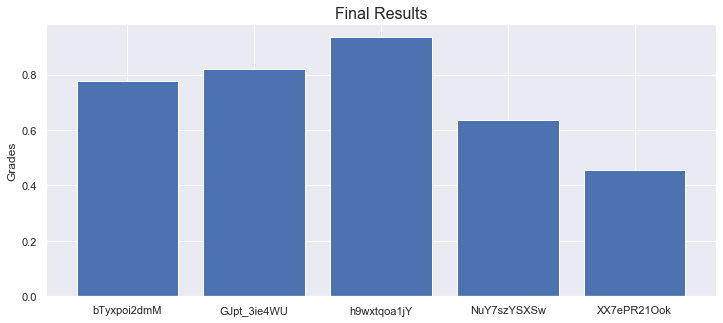

In [96]:


def hit_ratio(founded_section,labeled_section):
    founded_subsection_nums = founded_section.split('.')
    labeled_subsection_nums = labeled_section.split('.')
    last_match_level = 0
    for hierarchy_level in range(min(len(founded_subsection_nums),len(labeled_subsection_nums))):
        if founded_subsection_nums[hierarchy_level] != labeled_subsection_nums[hierarchy_level]:
            break
        last_match_level = hierarchy_level
    return 2**((last_match_level + 1) - len(labeled_subsection_nums))

'''Calculate grade for each video matching '''
videos_ = []
grades = []
for df_vid_results in all_results_matching:
    founded_titles = df_vid_results['Founded Title'].values.tolist()
    founded_sections = list(map(lambda x: re.match(r'((\d+\.)+\d*)',x).groups()[0],founded_titles))
    labeled_sections = df_vid_results['Chapter Section'].values.tolist()
    grades.append(sum(list(map(lambda x,y: hit_ratio(x,y),
                       founded_sections,labeled_sections)))/len(founded_sections))
    videos_.append(df_vid_results['Video'].values.tolist()[0])
    
fig,ax = plt.subplots(figsize = (12,5))    
pos_ = np.arange(len(videos_))
ax.bar(pos_,grades)

ax.set_ylabel('Grades')
ax.set_title('Final Results',fontsize=16)
ax.set_xticks(pos_)
ax.set_xticklabels(videos_)

plt.show()

In [98]:
print(grades)
print(sum(grades)/len(grades))

[0.7767857142857143, 0.8214285714285714, 0.9347826086956522, 0.6379310344827587, 0.45689655172413796]
0.7255648961233669
